In [1]:
from deepul.hw3_helper import *

In [2]:
device = 'cuda'

In [3]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


class Trainer:
    def __init__(self, model, train_data, test_data):
        self.model = model
        self.train_loader = data.DataLoader(train_data,
                                            batch_size=128,
                                            shuffle=True)
        self.test_loader = data.DataLoader(test_data,
                                           batch_size=128)
        self.loss_dict = lambda l: OrderedDict(loss=l[0] + l[1], recon_loss=l[0], reg_loss=l[1])

    def train(self, optimizer, epoch):
        self.model.train()

        losses = OrderedDict()
        for x in tqdm(self.train_loader, position=0, leave=False, desc=f'-{epoch}'):
            x = x.to(device)
            loss = self.loss_dict(self.model.loss(x))

            optimizer.zero_grad()
            loss['loss'].backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            for key, value in loss.items():
                if key not in losses:
                    losses[key] = []
                losses[key].append(value.item())
                avg_loss = np.mean(losses[key][-50:])
        return losses

    def eval_loss(self, data_loader):
        self.model.eval()
        total_losses = OrderedDict()
        with torch.no_grad():
            for x in data_loader:
                x = x.to(device)
                loss = self.loss_dict(self.model.loss(x))

                for key, value in loss.items():
                    total_losses[key] = total_losses.get(key, 0) + x.shape[0] * value.item()

            for key in total_losses.keys():
                total_losses[key] /= len(data_loader.dataset)

        return total_losses

    def train_epochs(self, epochs, lr):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        train_losses, test_losses = OrderedDict(), OrderedDict()
        for epoch in range(epochs):
            self.model.train()
            train_loss = self.train(optimizer, epoch)
            test_loss = self.eval_loss(self.test_loader)

            for i in train_loss.keys():
                if i not in train_losses:
                    train_losses[i] = []
                    test_losses[i] = []
                train_losses[i].extend(train_loss[i])
                test_losses[i].append(test_loss[i])
        self.train_losses = train_losses
        self.test_losses = test_losses


def create_dataset(data_loader, model):
    data = []
    with torch.no_grad():
        for x in data_loader:
            z = model.encode_code(x.to(device))
            data.append(z.long())
    return torch.cat(data, dim=0)


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )

    def forward(self, x):
        return x + self.model(x)


class VQVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_dim = code_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.embedding = nn.Embedding(code_size, code_dim)
        self.embedding.weight.data.uniform_(-1. / code_size, 1. / code_size)

        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode_code(self, x):
        x = 2 * x - 1
        with torch.no_grad():
            x = self.encoder(x)
            return self.code_forward(x)[2]

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def code_forward(self, z):
        weight = self.embedding.weight
        b, c, h, w = z.shape
        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) - 2 * torch.mm(flat_inputs, weight.t()) + (
                weight.t() ** 2).sum(dim=0, keepdim=True)
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.code_forward(z)
        return self.decoder(e_st), torch.mean((z - e.detach()) ** 2) + torch.mean((e - z.detach()) ** 2)

    def loss(self, x):
        x = 2 * x - 1
        tilda, diff = self(x)
        return F.mse_loss(tilda, x), diff


In [5]:
def VQVAE_run(train_data, test_data, code_dim, code_size):
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')

    vqvae = VQVAE(code_dim, code_size).to(device)

    trainer = Trainer(vqvae, train_data, test_data)
    trainer.train_epochs(epochs=20, lr=1e-3)

    vqvae_train_losses, vqvae_test_losses = trainer.train_losses['loss'], trainer.test_losses['loss']

    return vqvae, vqvae_train_losses, vqvae_test_losses, (trainer.train_loader, trainer.test_loader)


In [6]:
class Norm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class Conv2dM(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNNCell(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.model = nn.Sequential(
            Norm(dim),
            nn.ReLU(),
            Conv2dM('B', dim, dim // 2, 1),
            Norm(dim // 2),
            nn.ReLU(),
            Conv2dM('B', dim // 2, dim // 2, 3, padding=1),
            Norm(dim // 2),
            nn.ReLU(),
            Conv2dM('B', dim // 2, dim, 1)
        )

    def forward(self, x):
        return x + self.model(x)


class PixelCNN(nn.Module):
    def __init__(self, input_shape, code_size, dim=128, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(code_size, dim)

        self.model = nn.Sequential(
            Conv2dM('A', dim, dim, 7, padding=3),
            Norm(dim),
            nn.ReLU(),
            PixelCNNCell(dim),
            PixelCNNCell(dim),
            PixelCNNCell(dim),
            Norm(dim),
            nn.ReLU(),
            Conv2dM('B', dim, 64, 1),
            nn.ReLU(),
            Conv2dM('B', 64, code_size, 1)
        )
        self.input_shape = input_shape

    def forward(self, x):
        return self.model(self.embedding(x).permute(0, 3, 1, 2).contiguous())

    def loss(self, x):
        return F.cross_entropy(self(x), x), torch.tensor([0.0]).to(device)

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).long().to(device)
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, r, c]
                    logits = F.softmax(logits, dim=1)
                    samples[:, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples


In [7]:
def PixelCNN_run(datasets, vqvae, code_dim, code_size):
    model = PixelCNN(code_size=code_size, input_shape=(8, 8), dim=64, n_layers=1).to(device)
    train_data, test_data = create_dataset(datasets[0], vqvae), create_dataset(datasets[0], vqvae)

    trainer = Trainer(model, train_data, test_data)
    trainer.train_epochs(epochs=20, lr=1e-3)
    train_losses, test_losses = trainer.train_losses['loss'], trainer.test_losses['loss']

    for data in datasets[1]:
        x = data[:50].to(device)
        break

    z = vqvae.encode_code(x).detach()
    x = x.cpu().permute(0, 2, 3, 1).numpy()

    return train_losses, test_losses, vqvae.decode_code(model.sample(100).long()) * 255, np.stack(
        (x, vqvae.decode_code(z)), axis=1).reshape((-1, 32, 32, 3)) * 255


In [8]:
def q3(train_data, test_data, dset_id):
    vqvae, vqvae_train_losses, vqvae_test_losses, datasets = VQVAE_run(train_data, test_data, 256, 128)
    pixel_train_losses, pixel_test_losses, samples, reconstructions = PixelCNN_run(datasets, vqvae, 256, 128)
    return vqvae_train_losses, vqvae_test_losses, pixel_train_losses, pixel_test_losses, samples, reconstructions

VQ-VAE Final Test Loss: 0.0710
PixelCNN Prior Final Test Loss: 1.8390


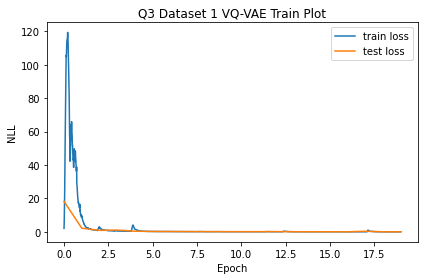

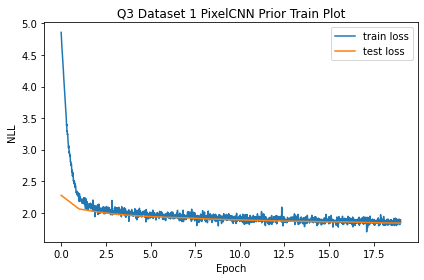

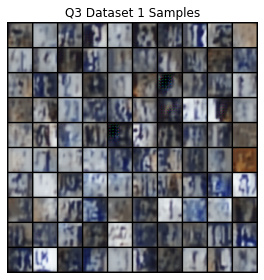

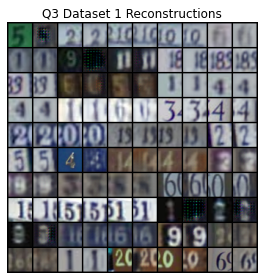

In [9]:
q3_save_results(1, q3)

VQ-VAE Final Test Loss: 0.0526
PixelCNN Prior Final Test Loss: 2.6570


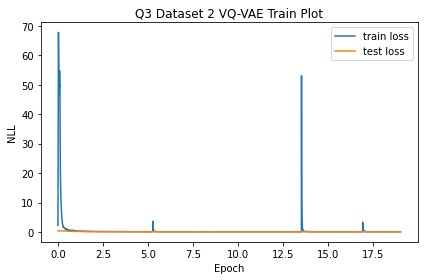

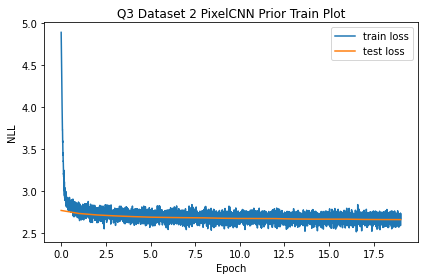

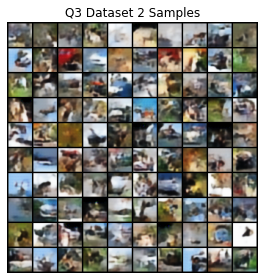

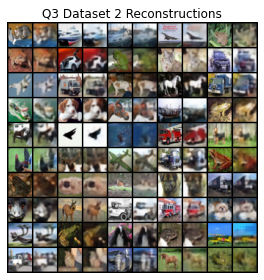

In [10]:
q3_save_results(2, q3)